# Image Classification Using Transfer Learning: 10 Monkey Species

## Author: Arash Sadeghzadeh

Data for this notebook can be retrieved from the following URL:
https://www.kaggle.com/datasets/slothkong/10-monkey-species

The dataset consists of two files, training and validation. Each folder contains 10 subforders labeled as n0~n9, each corresponding to a species.
Images are 400x300 px or larger and JPEG format. 

This dataset is intended as a test case for fine-grain classification tasks

We utilize Transfer Learning to classify the images. 
Two pretrained NNs are employed, i.e. MobileNetV2 and Inception V3.

Table of Content
- Exploring Data
- Some Samples
- Functions
- Using MobileNetV2
- Using InceptionV3 Model
- Conclusion



In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

First we set random seeds for the program (Python, NumPy, and TensorFlow):

In [2]:
tf.keras.utils.set_random_seed(1979)

Let's get familiar with dataset:

In [3]:
species_path = './data_monkeys/monkey_labels.csv'
df_desc = pd.read_csv(species_path, delimiter=',', header=0, 
                      names=['Label', 'Latin Name', 'Common Name', 'Train Images', 'Validation Images'])
df_desc.set_index('Label')

,Latin Name,Common Name,Train Images,Validation Images
Label,,,,
n0,alouatta_palliata\t,mantled_howler,131,26
n1,erythrocebus_patas\t,patas_monkey,139,28
n2,cacajao_calvus\t,bald_uakari,137,27
n3,macaca_fuscata\t,japanese_macaque,152,30
n4,cebuella_pygmea\t,pygmy_marmoset,131,26
n5,cebus_capucinus\t,white_headed_capuchin,141,28
n6,mico_argentatus\t,silvery_marmoset,132,26
n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
n8,aotus_nigriceps\t,black_headed_night_monkey,133,27


In the following, one can see the numbers of the training and validation samples for each specie:

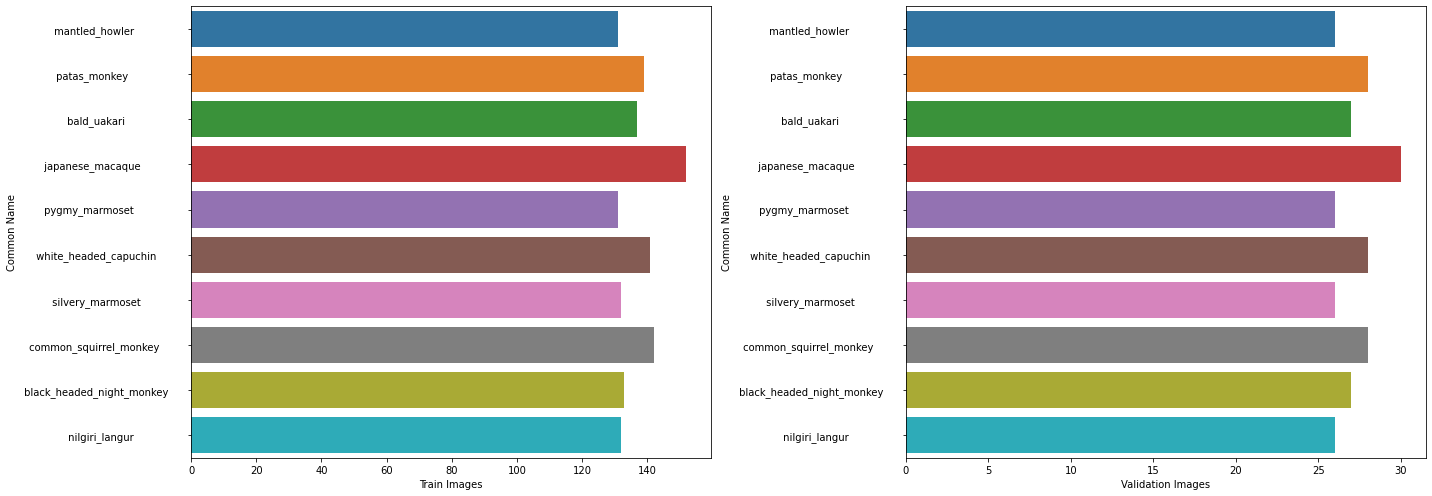

In [4]:
fig, axs = plt.subplots(1,2, figsize=(20,7))
sns.barplot(data=df_desc, x='Train Images', y='Common Name', ax=axs[0], )
sns.barplot(data=df_desc, x='Validation Images', y='Common Name', ax=axs[1])
plt.tight_layout()
plt.show()

In [5]:
tra_path = './data_monkeys/training/training'
val_path = './data_monkeys/validation/validation'

### Some Samples

Now, let's have a look at some samples from different species. In each row, one can see 3 pictures of a special specie.

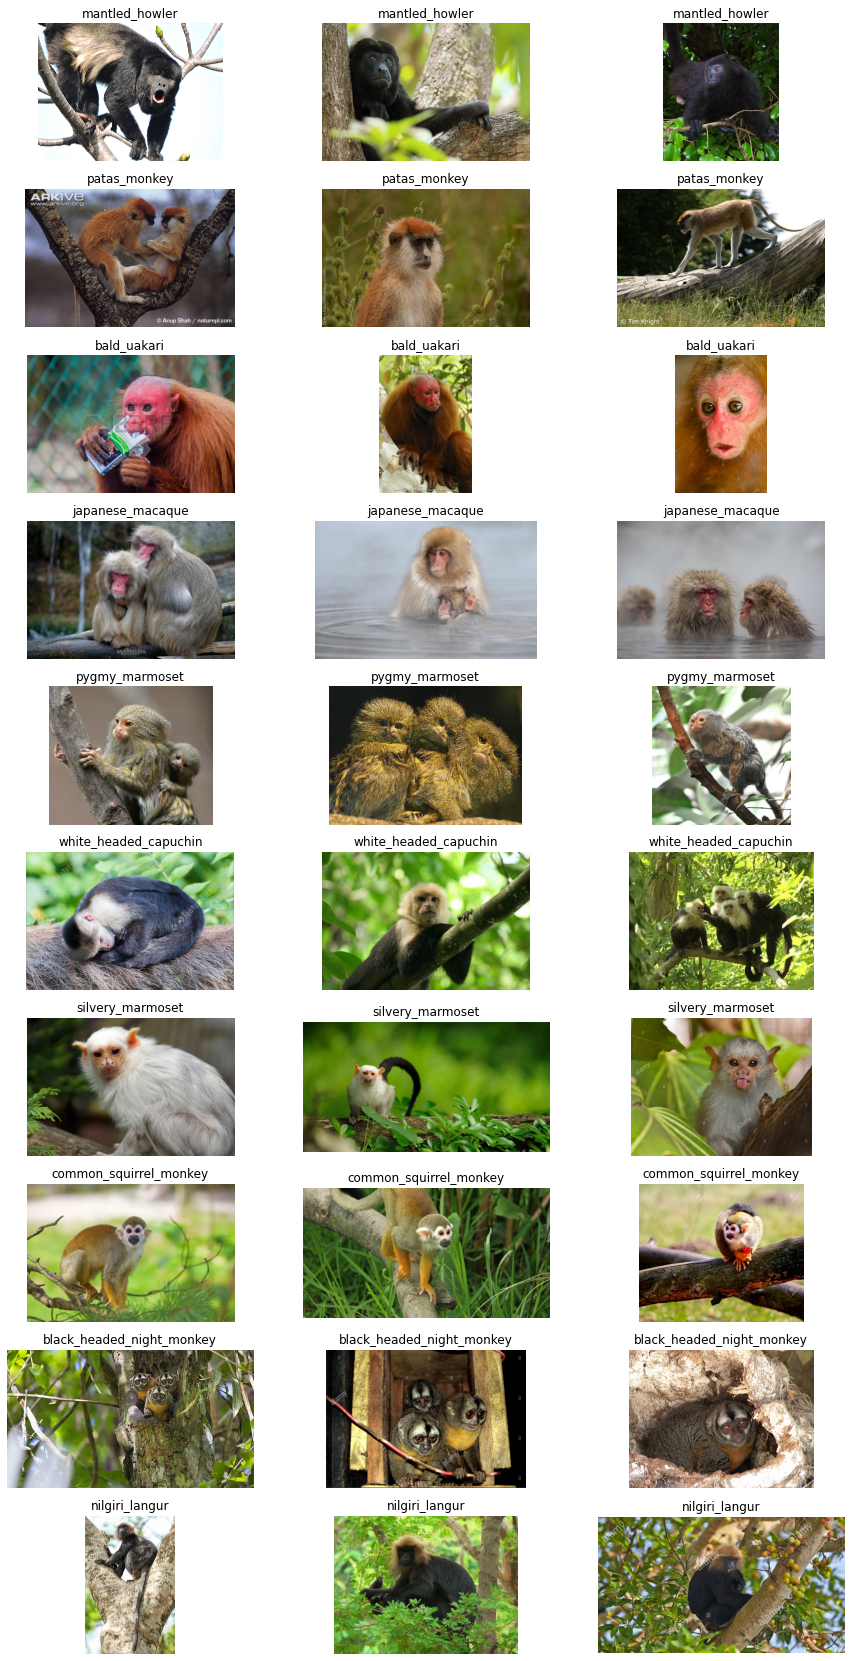

In [6]:
fig, ax = plt.subplots(10,3, figsize=(15,30))

for spe in range(10):
    tra_spe_path = os.path.join(tra_path, 'n' + str(spe))
    spe_list = os.listdir(tra_spe_path)
    spe_samples = random.sample(spe_list, 3)
    
    for num,sample_name in enumerate(spe_samples):
        sample_path = os.path.join(tra_spe_path, sample_name)
        img = mpimg.imread(sample_path)
        ax[spe, num].imshow(img, aspect='equal')
        ax[spe, num].set(title=df_desc.loc[spe, 'Common Name'].strip())
        ax[spe, num].axis('off')

## Functions

In this section, three functions are provided, which will be employed later.

The following is a function to illustrate the confusion matrix.

In [7]:
def depict_confusion_matrix(y_true, y_pred):
    '''This is a function to illustrate the confusion matrix
       for different classifiers we use in this notebook. '''
    
    sns.set_context('talk')
    sns.set_style('white')
    
    ConMat = confusion_matrix(y_true= y_true, y_pred=y_pred)
    plt.figure(figsize=(10,10))
    sns.heatmap(ConMat, annot=True, xticklabels=data_labels, yticklabels=data_labels, fmt='d', cmap='PuRd')
    ax = plt.gca()
    ax.set(xlabel='Prediction', ylabel='Ground Truth', title='Confusion Matrix')


In this function, we have the data generators for training and validation steps.

In [8]:
def train_validation_generators(preprocessing_fun=None, shuffle=True):
    '''This function provides train_generator and validation_generator'''
    
    train_datagen = ImageDataGenerator(rotation_range=40,
                                      shear_range=0.2,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      zoom_range = 0.2,
                                      preprocessing_function=preprocessing_fun,
                                      horizontal_flip=True)

    train_generator = train_datagen.flow_from_directory(tra_path,
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        shuffle=shuffle,
                                                        class_mode='categorical')


    validation_datagen = ImageDataGenerator(preprocessing_function=preprocessing_fun)

    validation_generator = validation_datagen.flow_from_directory(val_path,
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        shuffle=shuffle,
                                                        class_mode='categorical')
    return train_generator, validation_generator

Below, we have a function for illustrating the accuracy and validation accuracy after the training procedure:

In [9]:
def plot_accuracy_val_accuracy(history):
    '''This functions plots accuracy and val_accuracy for the classifier'''
    
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], 'r--', label='Val_Accuracy')
    plt.title('Accuracy and validation accuracy')
    plt.xlabel('epoch')
    plt.ylabel('value')

    plt.legend()
    plt.show()

## Using  MobileNetV2 Model

First, we use MobileNetV2 loaded with weights pre-trained on ImageNe. 
MobileNetV2 is very similar to the original MobileNet, except that it uses inverted residual blocks with bottlenecking features. Let's see how it works on our dataset.

In the following, we define the feature extraction part (base_model) based on Transfer Learning by employing MobileNetV2 model.

In [10]:
base_model = tf.keras.applications.MobileNetV2(include_top=False,
            weights='./mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')

base_model.trainable = False
base_model.summary()

output_layer = base_model.get_layer('out_relu')
last_output = output_layer.output

2022-09-01 19:37:13.586685: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "mobilenetv2_1.00_None"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                           

                                                                                                  
 block_3_expand (Conv2D)        (None, None, None,   3456        ['block_2_add[0][0]']            
                                144)                                                              
                                                                                                  
 block_3_expand_BN (BatchNormal  (None, None, None,   576        ['block_3_expand[0][0]']         
 ization)                       144)                                                              
                                                                                                  
 block_3_expand_relu (ReLU)     (None, None, None,   0           ['block_3_expand_BN[0][0]']      
                                144)                                                              
                                                                                                  
 block_3_p

                                192)                                                              
                                                                                                  
 block_6_expand_BN (BatchNormal  (None, None, None,   768        ['block_6_expand[0][0]']         
 ization)                       192)                                                              
                                                                                                  
 block_6_expand_relu (ReLU)     (None, None, None,   0           ['block_6_expand_BN[0][0]']      
                                192)                                                              
                                                                                                  
 block_6_pad (ZeroPadding2D)    (None, None, None,   0           ['block_6_expand_relu[0][0]']    
                                192)                                                              
          

 block_9_expand_BN (BatchNormal  (None, None, None,   1536       ['block_9_expand[0][0]']         
 ization)                       384)                                                              
                                                                                                  
 block_9_expand_relu (ReLU)     (None, None, None,   0           ['block_9_expand_BN[0][0]']      
                                384)                                                              
                                                                                                  
 block_9_depthwise (DepthwiseCo  (None, None, None,   3456       ['block_9_expand_relu[0][0]']    
 nv2D)                          384)                                                              
                                                                                                  
 block_9_depthwise_BN (BatchNor  (None, None, None,   1536       ['block_9_depthwise[0][0]']      
 malizatio

                                                                                                  
 block_12_depthwise (DepthwiseC  (None, None, None,   5184       ['block_12_expand_relu[0][0]']   
 onv2D)                         576)                                                              
                                                                                                  
 block_12_depthwise_BN (BatchNo  (None, None, None,   2304       ['block_12_depthwise[0][0]']     
 rmalization)                   576)                                                              
                                                                                                  
 block_12_depthwise_relu (ReLU)  (None, None, None,   0          ['block_12_depthwise_BN[0][0]']  
                                576)                                                              
                                                                                                  
 block_12_

 onv2D)                         960)                                                              
                                                                                                  
 block_15_depthwise_BN (BatchNo  (None, None, None,   3840       ['block_15_depthwise[0][0]']     
 rmalization)                   960)                                                              
                                                                                                  
 block_15_depthwise_relu (ReLU)  (None, None, None,   0          ['block_15_depthwise_BN[0][0]']  
                                960)                                                              
                                                                                                  
 block_15_project (Conv2D)      (None, None, None,   153600      ['block_15_depthwise_relu[0][0]']
                                160)                                                              
          

Now, we are able to define the classification part:

In [11]:
gap_out = tf.keras.layers.GlobalAveragePooling2D()(last_output)
model_out = tf.keras.layers.Dense(units=10, activation='softmax')(gap_out)

model = tf.keras.models.Model(inputs=base_model.input, outputs=model_out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                           

                                                                                                  
 block_3_expand (Conv2D)        (None, None, None,   3456        ['block_2_add[0][0]']            
                                144)                                                              
                                                                                                  
 block_3_expand_BN (BatchNormal  (None, None, None,   576        ['block_3_expand[0][0]']         
 ization)                       144)                                                              
                                                                                                  
 block_3_expand_relu (ReLU)     (None, None, None,   0           ['block_3_expand_BN[0][0]']      
                                144)                                                              
                                                                                                  
 block_3_p

                                192)                                                              
                                                                                                  
 block_6_expand_BN (BatchNormal  (None, None, None,   768        ['block_6_expand[0][0]']         
 ization)                       192)                                                              
                                                                                                  
 block_6_expand_relu (ReLU)     (None, None, None,   0           ['block_6_expand_BN[0][0]']      
                                192)                                                              
                                                                                                  
 block_6_pad (ZeroPadding2D)    (None, None, None,   0           ['block_6_expand_relu[0][0]']    
                                192)                                                              
          

 block_9_expand_BN (BatchNormal  (None, None, None,   1536       ['block_9_expand[0][0]']         
 ization)                       384)                                                              
                                                                                                  
 block_9_expand_relu (ReLU)     (None, None, None,   0           ['block_9_expand_BN[0][0]']      
                                384)                                                              
                                                                                                  
 block_9_depthwise (DepthwiseCo  (None, None, None,   3456       ['block_9_expand_relu[0][0]']    
 nv2D)                          384)                                                              
                                                                                                  
 block_9_depthwise_BN (BatchNor  (None, None, None,   1536       ['block_9_depthwise[0][0]']      
 malizatio

                                                                                                  
 block_12_depthwise (DepthwiseC  (None, None, None,   5184       ['block_12_expand_relu[0][0]']   
 onv2D)                         576)                                                              
                                                                                                  
 block_12_depthwise_BN (BatchNo  (None, None, None,   2304       ['block_12_depthwise[0][0]']     
 rmalization)                   576)                                                              
                                                                                                  
 block_12_depthwise_relu (ReLU)  (None, None, None,   0          ['block_12_depthwise_BN[0][0]']  
                                576)                                                              
                                                                                                  
 block_12_

 onv2D)                         960)                                                              
                                                                                                  
 block_15_depthwise_BN (BatchNo  (None, None, None,   3840       ['block_15_depthwise[0][0]']     
 rmalization)                   960)                                                              
                                                                                                  
 block_15_depthwise_relu (ReLU)  (None, None, None,   0          ['block_15_depthwise_BN[0][0]']  
                                960)                                                              
                                                                                                  
 block_15_project (Conv2D)      (None, None, None,   153600      ['block_15_depthwise_relu[0][0]']
                                160)                                                              
          

Let's prepare the data generators for training and validaition steps:

In [12]:
train_generator, validation_generator = train_validation_generators(preprocessing_fun=
                                                        tf.keras.applications.mobilenet.preprocess_input)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

best_model_callback = tf.keras.callbacks.ModelCheckpoint('Classification_mobilenet.h5', monitor='val_accuracy', save_best_only=True, 
                                                         verbose=1)


history = model.fit(train_generator, batch_size=32, epochs=20, 
                    validation_data=validation_generator, callbacks=[best_model_callback] )

Epoch 1/20
35/35 [==============================] - ETA: 0s - loss: 1.3799 - accuracy: 0.6047
Epoch 1: val_accuracy improved from -inf to 0.91912, saving model to Classification_mobilenet.h5
35/35 [==============================] - 64s 2s/step - loss: 1.3799 - accuracy: 0.6047 - val_loss: 0.5607 - val_accuracy: 0.9191
Epoch 2/20
35/35 [==============================] - ETA: 0s - loss: 0.3904 - accuracy: 0.9162
Epoch 2: val_accuracy improved from 0.91912 to 0.95588, saving model to Classification_mobilenet.h5
35/35 [==============================] - 58s 2s/step - loss: 0.3904 - accuracy: 0.9162 - val_loss: 0.2646 - val_accuracy: 0.9559
Epoch 3/20
35/35 [==============================] - ETA: 0s - loss: 0.2293 - accuracy: 0.9499
Epoch 3: val_accuracy improved from 0.95588 to 0.96691, saving model to Classification_mobilenet.h5
35/35 [==============================] - 58s 2s/step - loss: 0.2293 - accuracy: 0.9499 - val_loss: 0.1861 - val_accuracy: 0.9669
Epoch 4/20
35/35 [================

Using MobileNetV2, we obtained an accuracy about 0.978 for our validation set.

Now, we can see the accuracy and  the validaition accuracy plots:

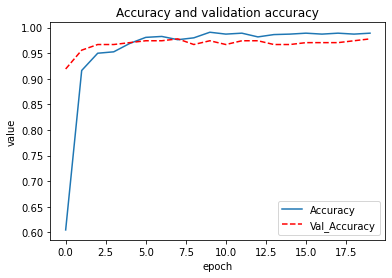

In [14]:
plot_accuracy_val_accuracy(history)

Thanks to callbacks, now we are able to load the best obtained model from the validation accuracy viewpoint:

In [15]:
model = tf.keras.models.load_model('./Classification_mobilenet.h5')
model.evaluate(validation_generator)

9/9 [==============================] - 12s 1s/step - loss: 0.1013 - accuracy: 0.9779


[0.10128263384103775, 0.9779411554336548]

Now, let's compute the predictions for the validation set and then have a look at the confusion matrix:

In [16]:
# Note that here we set shuffle=False

_ , validation_generator_eval = train_validation_generators(preprocessing_fun=tf.keras.applications.mobilenet.preprocess_input,
                            shuffle=False)

y_pred = np.argmax(model.predict(validation_generator_eval), axis=1)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [17]:
y_true = validation_generator_eval.labels

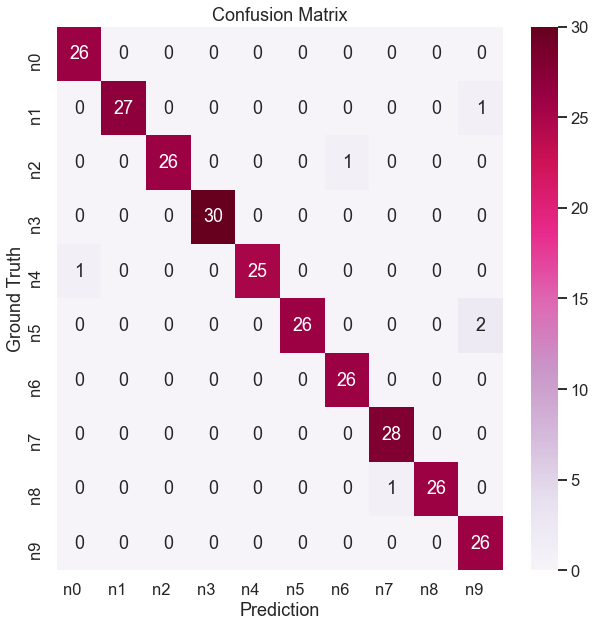

In [18]:
data_labels = df_desc['Label'].values
depict_confusion_matrix(y_true, y_pred)

As one can see, 6 images from total 272 have been misclassified. Using the confusion matrix, one can see which images are misclassified. 

## Using Inception V3 Model

In [19]:
base_model = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

base_model.trainable = False
base_model.summary()

output_layer = base_model.get_layer('mixed8')
last_output = output_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

 batch_normalization_5 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 12, 12, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 12, 12, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 12, 12, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 5, 5, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 5, 5, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 5, 5, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [20]:
gap_out = tf.keras.layers.GlobalAveragePooling2D()(last_output)
dns_out = tf.keras.layers.Dense(units=2024, activation='relu')(gap_out)
drop_out = tf.keras.layers.Dropout(0.2)(dns_out)
model_out = tf.keras.layers.Dense(units=10, activation='softmax')(drop_out)

model = tf.keras.models.Model(inputs=base_model.input, outputs=model_out)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

 batch_normalization_5 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 12, 12, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 12, 12, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 12, 12, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

In [21]:
train_geberator, validation_generator = train_validation_generators(preprocessing_fun=
                                                                    tf.keras.applications.inception_v3.preprocess_input)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [22]:
best_model_callback = tf.keras.callbacks.ModelCheckpoint('Classification_Inception.h5', monitor='val_accuracy',
                                                         save_best_only=True, verbose=1)

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator, batch_size=32, epochs=20, validation_data=validation_generator, 
                    callbacks=[best_model_callback])

Epoch 1/20
35/35 [==============================] - ETA: 0s - loss: 1.0264 - accuracy: 0.6940
Epoch 1: val_accuracy improved from -inf to 0.93382, saving model to Classification_Inception.h5
35/35 [==============================] - 76s 2s/step - loss: 1.0264 - accuracy: 0.6940 - val_loss: 0.2518 - val_accuracy: 0.9338
Epoch 2/20
35/35 [==============================] - ETA: 0s - loss: 0.2835 - accuracy: 0.9199
Epoch 2: val_accuracy improved from 0.93382 to 0.97059, saving model to Classification_Inception.h5
35/35 [==============================] - 73s 2s/step - loss: 0.2835 - accuracy: 0.9199 - val_loss: 0.1167 - val_accuracy: 0.9706
Epoch 3/20
35/35 [==============================] - ETA: 0s - loss: 0.1740 - accuracy: 0.9499
Epoch 3: val_accuracy improved from 0.97059 to 0.97426, saving model to Classification_Inception.h5
35/35 [==============================] - 73s 2s/step - loss: 0.1740 - accuracy: 0.9499 - val_loss: 0.0895 - val_accuracy: 0.9743
Epoch 4/20
35/35 [================

As one can see, the obtained validation accuracy for our dataset is about 0.993 implying that the classifier performs a great job. 

Now, lets have a look at the accuracy and the validation accuracy:

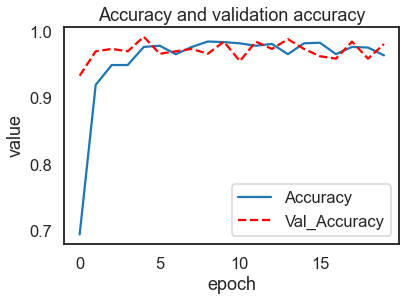

In [23]:
plot_accuracy_val_accuracy(history)

Now, lets load the best obtained model:

In [24]:
model = tf.keras.models.load_model('./Classification_Inception.h5')
model.evaluate(validation_generator)

9/9 [==============================] - 13s 1s/step - loss: 0.0566 - accuracy: 0.9926


[0.05658493936061859, 0.9926470518112183]

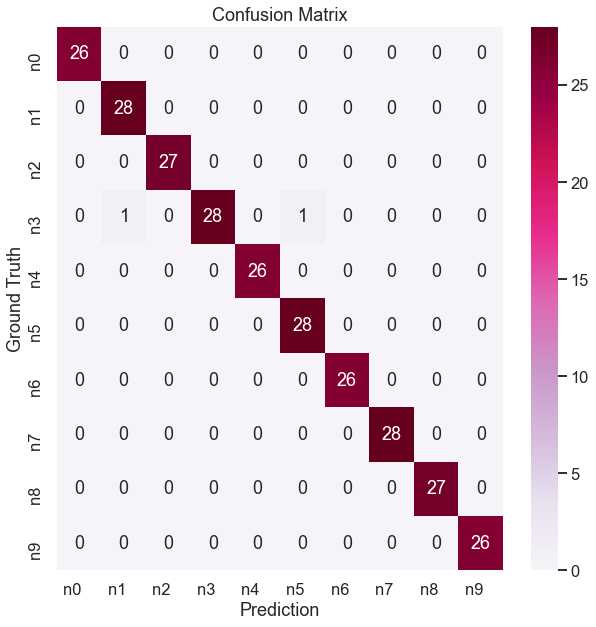

In [25]:
y_pred = np.argmax(model.predict(validation_generator_eval), axis=1)
y_true = validation_generator_eval.labels

depict_confusion_matrix(y_true, y_pred)

Using the confusion matrix, one can see that two mages from total 272 images are misclassified. Obviousely, two images of n3 classare identified as n1 and n5 classes.
The obtained accuracy using the InceptionV3 model is really high (0.993) implying that this classifier performs well on our validation set.